In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Fruits classification with VGG16 and Trasnfer Learning

**Import Libraries**

In [2]:
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

**Reading the Dataset**

In [3]:
# training and testing path
train_path = "../input/fruits/fruits-360/Training"
valid_path = "../input/fruits/fruits-360/Test"

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

**Let's look at an image to get an idea**

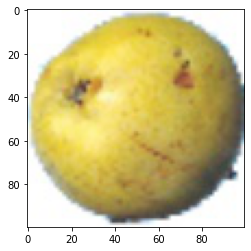

In [4]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

**Some Preprocessing and training Options**

In [5]:
# re-size all images to this size
IMAGE_SIZE = [100,100]

# training config
epochs = 5
batch_size = 32

**Adding Preprocessing Layer in front of VGG**

In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3] , weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


**I am using Transfer Learning that's why here there is no need to re-train train existing weights**

In [7]:
for layer in vgg.layers:
    layer.trainable = False

*Here I am adding Dense Layer with *softmax* actiation function

# YOU CAN ADD MORE LAYERS IF YOU WANT

In [8]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation="softmax")(x)

**Create a model object**

In [9]:
model = Model(inputs=vgg.input, outputs=prediction)

**View the structure of the model**

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

**Complining the model with *categorical_crossentropy* loss fucntion and *rmsprop* as optimizer method**

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

**Create an instance of ImageDataGenerator for data augmentation**

In [12]:
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

**Get label mapping for confusion matrix plot which will be used later in this notebook**

In [13]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

**Sould be a strangely colored image (due to VGG weights being RGB)**

min: 0.069633566 max: 255.0


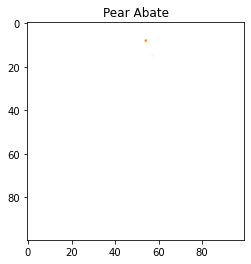

In [14]:
for x, y in test_gen:
    print("min:", x[0].min(),"max:",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

**Create generators**

In [15]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


**Train the model**

In [16]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps = len(valid_image_files) // batch_size,
)

Epoch 1/5
2115/2115 [==============================] - 712s 337ms/step - loss: 4.0528 - accuracy: 0.7898 - val_loss: 4.3672 - val_accuracy: 0.8174
Epoch 2/5
2115/2115 [==============================] - 383s 181ms/step - loss: 1.3211 - accuracy: 0.9235 - val_loss: 3.7170 - val_accuracy: 0.8584
Epoch 3/5
2115/2115 [==============================] - 415s 196ms/step - loss: 0.9343 - accuracy: 0.9465 - val_loss: 4.0464 - val_accuracy: 0.8609
Epoch 4/5
2115/2115 [==============================] - 416s 197ms/step - loss: 0.8147 - accuracy: 0.9557 - val_loss: 3.3468 - val_accuracy: 0.8865
Epoch 5/5
2115/2115 [==============================] - 424s 200ms/step - loss: 0.6710 - accuracy: 0.9636 - val_loss: 3.0265 - val_accuracy: 0.8998


**Making a function for confusion matrix**

In [18]:
def get_confusion_matrix(data_path, N):
    print("Generating Confusion Matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
        
        cm = confusion_matrix(targets, predictions)
        return cm

**Calling Confusion Matrix**

In [19]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating Confusion Matrix 67692
Found 67692 images belonging to 131 classes.
[[62  2]
 [ 0  0]]
Generating Confusion Matrix 22688
Found 22688 images belonging to 131 classes.
[[61  1  1  1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


**Plot some data for further analysis**

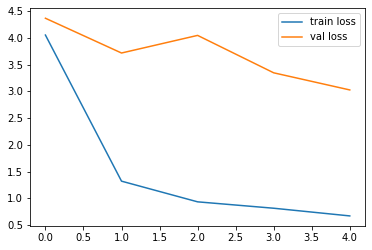

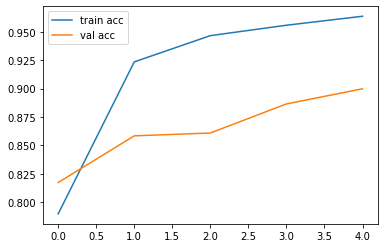

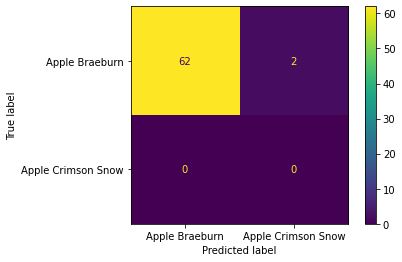

In [31]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label="train acc")
plt.plot(r.history['val_accuracy'], label="val acc")
plt.legend()
plt.show()

from utils import plot_confusion_matrix
plot_confusion_matrix(r, cm, labels)
plot_confusion_matrix(valid_cm, labels, title="Validation Confusion Matrix")